In [1]:
import json
from pandas import Series, DataFrame
import pandas as pd
from bs4 import BeautifulSoup
from tqdm.notebook import tqdm
import numpy as np

tqdm.pandas()

## Load comments

In [2]:
import re
def split_html_paragraphs(html:str):
    # return [s for s in re.split(r"</?p>|<br/?>", html) if len(s.strip()) > 0]
    return [s for s in re.split(r"<br/?>", html) if len(s.strip()) > 0]

In [3]:
with open("./data/comments.json") as f:
    comment_dict = json.loads(f.read())
    comment_dict = [c for c in comment_dict if (c['pageUrl'] is not None) and (c['htmlBody'] is not None)]

for c in comment_dict:
    if "?commentId=" in c['pageUrl']:
        c['commentId'] = c['pageUrl'].split("?commentId=")[1]
    else:
        c['commentId'] = "discussion#" + c['pageUrl'].split("discussion#")[1]

comment_info = DataFrame(comment_dict).set_index("commentId")
comment_info = comment_info[~comment_info.index.duplicated()]
# comment_htmls = Series({c['commentId']: c['htmlBody'] for c in comment_dict})

# comment_texts = comment_info.htmlBody.progress_map(lambda h: BeautifulSoup(h, features="html.parser").get_text())
# comment_texts = comment_texts.map(str.strip)
# comment_texts = comment_texts[comment_texts.map(len) > 50]
# comment_texts.to_csv("./data/comment_texts.csv")

# comment_texts = pd.read_csv("./data/comment_texts.csv").set_index("text").postId
# comment_texts.size

In [4]:
html_split = comment_info.htmlBody.map(split_html_paragraphs)
comment_htmls_split = pd.concat(
    [comment_info.htmlBody[html_split.map(len) == 1]] + 
    [Series(ts, index=[f'{cid}--{i}' for i in range(len(ts))]) for cid,ts in html_split[html_split.map(len) > 1].items()]
)

In [5]:
comment_info_split = comment_info.loc[comment_htmls_split.index.map(lambda x: x.split('--')[0])].copy()
comment_info_split.index = comment_htmls_split.index
comment_info_split['htmlBody'] = comment_htmls_split.values
comment_info_split['text'] = comment_info_split.htmlBody.progress_map(lambda h: BeautifulSoup(h, features="html.parser").get_text())

comment_info_split['text'] = comment_info_split['text'].map(lambda x: ' '.join([w for w in x.split() if len(w) < 40])) # Remove non-words
# TODO: there are still some people writing all in bullet-points, so we also need to split lists with long bullet-points, but those are minorities
# Removing these long comments:
comment_info_split = comment_info_split[(comment_info_split.text.map(len) < 5000) & (comment_info_split.text.map(len) > 70)]
comment_info_split.shape

  0%|          | 0/106839 [00:00<?, ?it/s]

/home/vpetukhov/local/miniconda3/envs/interactive_classification/lib/python3.8/site-packages/bs4/__init__.py:435: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.
  warnings.warn(
/home/vpetukhov/local/miniconda3/envs/interactive_classification/lib/python3.8/site-packages/bs4/__init__.py:404: MarkupResemblesLocatorWarning: The input looks more like a URL than markup. You may want to use an HTTP client like requests to get the document behind the URL, and feed that document to Beautiful Soup.
  warnings.warn(


(89918, 5)

<AxesSubplot:>

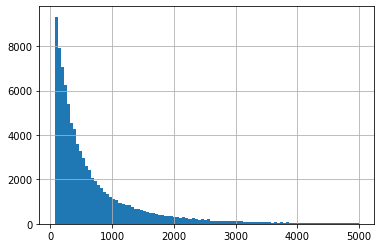

In [6]:
comment_info_split.text.map(len).hist(bins=100)

In [7]:
# tpid = comment_info_split.text.map(len)[comment_info_split.text.map(len) < 5000].sort_values().index[-8]
# comment_info_split.loc[tpid].pageUrl

## Classify

In [269]:
# with open("./data/example_proposals.txt") as f:
#     sents = f.read()
    
# sents = [s for s in sents.split("\n") if len(s) > 0]

In [8]:
from flair.models import TARSClassifier
from flair.data import Sentence

tars = TARSClassifier.load('tars-base')

2022-07-15 16:38:46,458 loading file /home/vpetukhov/.flair/models/tars-base-v8.pt


In [9]:
def get_class_score(clf, cl_lab, text):
    st = Sentence(text)
    clf.predict_zero_shot(st, [cl_lab], multi_label=False)

    lab = st.get_label()
    tag = lab.value
    score = lab.score if lab.value == cl_lab else 0.0
    return score

In [11]:
samp_ids = np.random.choice(comment_info_split.index, size=2000, replace=False)
class_probs = comment_info_split.text[samp_ids].progress_map(lambda t: get_class_score(tars, "project proposal", t))
# class_probs.to_pickle("./class_probs.pkl")
# class_probs = pd.read_pickle("./class_probs.pkl")
(class_probs > 0.75).mean()

  0%|          | 0/2000 [00:00<?, ?it/s]

0.0275

## Wrapper for the UI integration

In [13]:
import sqlite3 as db

Create labeled table:

In [14]:
def get_target_prob_ids(class_probs:Series, target_prob:float, n_samples:int=10, labeled_ids=None):
    if labeled_ids is None:
        labeled_ids = []
    return (class_probs[class_probs.index.difference(labeled_ids)] - target_prob).abs().sort_values()[:n_samples].index

In [15]:
# conn = db.connect('./backend/labels.db')
# labeled_ids = pd.read_sql_query("SELECT postId FROM labels", conn).postId.values
labeled_ids = []
closest_ids = get_target_prob_ids(class_probs, target_prob=1.0, n_samples=20, labeled_ids=labeled_ids)

In [16]:
comment_info_split.text[closest_ids].reset_index().to_csv("./data/to_classify.csv", index=True)

In [11]:
# pd.read_sql_query("SELECT * FROM labels", conn)

In [ ]:
# classes = ["project proposal"]

# for s in sents:
#     st = Sentence(s)
#     tars.predict_zero_shot(st, classes, multi_label=False)
#     print(st)

## Fine-tune

In [20]:
conn = db.connect('./backend/labels.db')
train_df = pd.read_sql_query("SELECT text,label FROM labels", conn)
train_df['label'] = np.array(['', 'project proposal'])[train_df['label'].values]
train_df.to_csv('./output/flair_train/train.csv', sep='\t')
train_df.to_csv('./output/flair_train/dev.csv', sep='\t')

train_df.sort_values("label", ascending=False).head(3)

,text,label
0,The suggested EA project / org: work to identi...,project proposal
18,As a concrete program related to the safety of...,project proposal
30,"There is the Earth Species project, an ""open-s...",project proposal


In [21]:
from flair.data import Corpus
from flair.datasets import CSVClassificationCorpus

column_name_map = {1: 'text', 2: 'label'}
corpus = CSVClassificationCorpus("./output/flair_train/", column_name_map, label_type="label", skip_header=True, delimiter='\t', no_class_label="")
label_dict = corpus.make_label_dictionary(label_type="label")

2022-07-15 17:15:43,410 Reading data from output/flair_train
2022-07-15 17:15:43,411 Train: output/flair_train/train.csv
2022-07-15 17:15:43,411 Dev: output/flair_train/dev.csv
2022-07-15 17:15:43,412 Test: None
2022-07-15 17:15:43,415 Computing label dictionary. Progress:


3it [00:00, 781.79it/s]

2022-07-15 17:15:43,421 Dictionary created for label 'label' with 2 values: project proposal (seen 3 times)


In [22]:
tars.add_and_switch_to_new_task("jobs", label_dictionary=label_dict, label_type="label")

In [23]:
from flair.models import TARSClassifier
from flair.trainers import ModelTrainer

trainer = ModelTrainer(tars, corpus)

trainer.train(base_path='./output/flair_train/artifacts/', # path to store the model artifacts
              learning_rate=0.02, # use very small learning rate
              mini_batch_size=16,
              mini_batch_chunk_size=4, # optionally set this if transformer is too much for your machine
              max_epochs=10, # terminate after 10 epochs
              )

2022-07-15 17:15:47,269 ----------------------------------------------------------------------------------------------------
2022-07-15 17:15:47,272 Model: "TARSClassifier(
  (tars_model): TextClassifier(
    (decoder): Linear(in_features=768, out_features=2, bias=True)
    (dropout): Dropout(p=0.0, inplace=False)
    (locked_dropout): LockedDropout(p=0.0)
    (word_dropout): WordDropout(p=0.0)
    (loss_function): CrossEntropyLoss()
    (document_embeddings): TransformerDocumentEmbeddings(
      (model): BertModel(
        (embeddings): BertEmbeddings(
          (word_embeddings): Embedding(30522, 768, padding_idx=0)
          (position_embeddings): Embedding(512, 768)
          (token_type_embeddings): Embedding(2, 768)
          (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
          (dropout): Dropout(p=0.1, inplace=False)
        )
        (encoder): BertEncoder(
          (layer): ModuleList(
            (0): BertLayer(
              (attention): BertAttentio

/home/vpetukhov/local/miniconda3/envs/interactive_classification/lib/python3.8/site-packages/flair/trainers/trainer.py:64: UserWarning: There should be no best model saved at epoch 1 except there is a model from previous trainings in your training folder. All previous best models will be deleted.
  warnings.warn(


2022-07-15 17:15:48,503 epoch 1 - iter 1/1 - loss 0.05037894 - samples/sec: 13.77 - lr: 0.020000
2022-07-15 17:15:48,505 ----------------------------------------------------------------------------------------------------
2022-07-15 17:15:48,506 EPOCH 1 done: loss 0.0504 - lr 0.020000


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.98it/s]

2022-07-15 17:15:48,846 Evaluating as a multi-label problem: False
2022-07-15 17:15:48,858 DEV : loss 0.003526731627061963 - f1-score (micro avg)  1.0
2022-07-15 17:15:48,864 BAD EPOCHS (no improvement): 0
2022-07-15 17:15:48,865 saving best model


2022-07-15 17:15:49,454 ----------------------------------------------------------------------------------------------------
2022-07-15 17:15:50,608 epoch 2 - iter 1/1 - loss 0.00097065 - samples/sec: 14.40 - lr: 0.020000
2022-07-15 17:15:50,611 ----------------------------------------------------------------------------------------------------
2022-07-15 17:15:50,612 EPOCH 2 done: loss 0.0010 - lr 0.020000


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.90it/s]

2022-07-15 17:15:50,961 Evaluating as a multi-label problem: False
2022-07-15 17:15:50,972 DEV : loss 0.002646335167810321 - f1-score (micro avg)  1.0
2022-07-15 17:15:50,978 BAD EPOCHS (no improvement): 0
2022-07-15 17:15:50,979 ----------------------------------------------------------------------------------------------------


2022-07-15 17:15:52,077 epoch 3 - iter 1/1 - loss 0.00172945 - samples/sec: 15.16 - lr: 0.020000
2022-07-15 17:15:52,080 ----------------------------------------------------------------------------------------------------
2022-07-15 17:15:52,081 EPOCH 3 done: loss 0.0017 - lr 0.020000


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.15it/s]

2022-07-15 17:15:52,403 Evaluating as a multi-label problem: False
2022-07-15 17:15:52,417 DEV : loss 0.001737547921948135 - f1-score (micro avg)  1.0
2022-07-15 17:15:52,423 BAD EPOCHS (no improvement): 0
2022-07-15 17:15:52,424 ----------------------------------------------------------------------------------------------------


2022-07-15 17:15:53,770 epoch 4 - iter 1/1 - loss 0.00105890 - samples/sec: 12.40 - lr: 0.020000
2022-07-15 17:15:53,774 ----------------------------------------------------------------------------------------------------
2022-07-15 17:15:53,775 EPOCH 4 done: loss 0.0011 - lr 0.020000


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.82it/s]

2022-07-15 17:15:54,139 Evaluating as a multi-label problem: False
2022-07-15 17:15:54,152 DEV : loss 0.0013952214503660798 - f1-score (micro avg)  1.0
2022-07-15 17:15:54,159 BAD EPOCHS (no improvement): 0
2022-07-15 17:15:54,162 ----------------------------------------------------------------------------------------------------


2022-07-15 17:15:55,468 epoch 5 - iter 1/1 - loss 0.00073950 - samples/sec: 12.70 - lr: 0.020000
2022-07-15 17:15:55,470 ----------------------------------------------------------------------------------------------------
2022-07-15 17:15:55,471 EPOCH 5 done: loss 0.0007 - lr 0.020000


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.67it/s]

2022-07-15 17:15:55,851 Evaluating as a multi-label problem: False
2022-07-15 17:15:55,864 DEV : loss 0.0011605862528085709 - f1-score (micro avg)  1.0
2022-07-15 17:15:55,870 BAD EPOCHS (no improvement): 0
2022-07-15 17:15:55,871 ----------------------------------------------------------------------------------------------------


2022-07-15 17:15:57,200 epoch 6 - iter 1/1 - loss 0.00051253 - samples/sec: 12.46 - lr: 0.020000
2022-07-15 17:15:57,202 ----------------------------------------------------------------------------------------------------
2022-07-15 17:15:57,202 EPOCH 6 done: loss 0.0005 - lr 0.020000


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.17it/s]

2022-07-15 17:15:57,522 Evaluating as a multi-label problem: False
2022-07-15 17:15:57,535 DEV : loss 0.001008349470794201 - f1-score (micro avg)  1.0
2022-07-15 17:15:57,542 BAD EPOCHS (no improvement): 0
2022-07-15 17:15:57,543 ----------------------------------------------------------------------------------------------------


2022-07-15 17:15:58,687 epoch 7 - iter 1/1 - loss 0.00072862 - samples/sec: 14.51 - lr: 0.020000
2022-07-15 17:15:58,690 ----------------------------------------------------------------------------------------------------
2022-07-15 17:15:58,691 EPOCH 7 done: loss 0.0007 - lr 0.020000


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.86it/s]

2022-07-15 17:15:59,045 Evaluating as a multi-label problem: False
2022-07-15 17:15:59,057 DEV : loss 0.0008032931946218014 - f1-score (micro avg)  1.0
2022-07-15 17:15:59,063 BAD EPOCHS (no improvement): 0
2022-07-15 17:15:59,064 ----------------------------------------------------------------------------------------------------


2022-07-15 17:16:00,313 epoch 8 - iter 1/1 - loss 0.00054428 - samples/sec: 13.27 - lr: 0.020000
2022-07-15 17:16:00,316 ----------------------------------------------------------------------------------------------------
2022-07-15 17:16:00,317 EPOCH 8 done: loss 0.0005 - lr 0.020000


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.71it/s]

2022-07-15 17:16:00,689 Evaluating as a multi-label problem: False
2022-07-15 17:16:00,702 DEV : loss 0.0007176553481258452 - f1-score (micro avg)  1.0
2022-07-15 17:16:00,708 BAD EPOCHS (no improvement): 0
2022-07-15 17:16:00,710 ----------------------------------------------------------------------------------------------------


2022-07-15 17:16:02,168 epoch 9 - iter 1/1 - loss 0.00045894 - samples/sec: 11.31 - lr: 0.020000
2022-07-15 17:16:02,172 ----------------------------------------------------------------------------------------------------
2022-07-15 17:16:02,173 EPOCH 9 done: loss 0.0005 - lr 0.020000


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.39it/s]

2022-07-15 17:16:02,596 Evaluating as a multi-label problem: False
2022-07-15 17:16:02,610 DEV : loss 0.0006246347329579294 - f1-score (micro avg)  1.0
2022-07-15 17:16:02,617 BAD EPOCHS (no improvement): 0
2022-07-15 17:16:02,619 ----------------------------------------------------------------------------------------------------


2022-07-15 17:16:04,042 epoch 10 - iter 1/1 - loss 0.00029327 - samples/sec: 11.68 - lr: 0.020000
2022-07-15 17:16:04,044 ----------------------------------------------------------------------------------------------------
2022-07-15 17:16:04,046 EPOCH 10 done: loss 0.0003 - lr 0.020000


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.68it/s]

2022-07-15 17:16:04,424 Evaluating as a multi-label problem: False
2022-07-15 17:16:04,437 DEV : loss 0.0005788668640889227 - f1-score (micro avg)  1.0
2022-07-15 17:16:04,445 BAD EPOCHS (no improvement): 0


2022-07-15 17:16:05,211 Test data not provided setting final score to 0


{'test_score': 0,
 'dev_score_history': [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0],
 'train_loss_history': [0.05037894348303477,
  0.0009706520165006319,
  0.0017294536034266155,
  0.0010589007288217545,
  0.0007394989176342884,
  0.0005125256332879266,
  0.0007286227773874998,
  0.0005442828017597398,
  0.0004589410576348503,
  0.0002932692295871675],
 'dev_loss_history': [0.003526731627061963,
  0.002646335167810321,
  0.001737547921948135,
  0.0013952214503660798,
  0.0011605862528085709,
  0.001008349470794201,
  0.0008032931946218014,
  0.0007176553481258452,
  0.0006246347329579294,
  0.0005788668640889227]}

In [24]:
samp_ids = np.random.choice(comment_info_split.index, size=2000, replace=False)
class_probs = comment_info_split.text[samp_ids].progress_map(lambda t: get_class_score(tars, "project proposal", t))
(class_probs > 0.75).mean()

  0%|          | 0/2000 [00:00<?, ?it/s]

0.167

In [25]:
labeled_ids = pd.read_sql_query("SELECT postId FROM labels", conn).postId.values
closest_ids = get_target_prob_ids(class_probs, target_prob=1.0, n_samples=50, labeled_ids=labeled_ids)

- Can use Colab as a training set
- Can contribute GraphQL documentation as our result

In [26]:
comment_info_split.text[closest_ids].reset_index().to_csv("./data/to_classify.csv", index=True)